# Recovering SSDV image 0xAB, transmitted on 2019-02-27 08:20

In [1]:
%matplotlib inline

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

In [27]:
fs = 40000 # sample rate

We load a file containing the relevant GMSK transmission. The recording was done at the Dwingeloo radiotelescope and can be obtained [here](https://charon.camras.nl/public/dslwp-b/DSLWP-B_PI9CAM_2019-02-27T07:26:01_436.4MHz_40ksps_complex.raw). Remember to edit the path below to point to the correct file.

In [28]:
skip = 3200 * fs * 8 # first transmission seems to have a missing samples from the recorder
skip = 5550 * fs * 8
length = 140 * fs
with open('/home/daniel/Descargas/DSLWP-B_PI9CAM_2019-02-27T07_26_01_436.4MHz_40ksps_complex.raw') as f:
    f.seek(skip)
    x = np.fromfile(f, dtype='complex64', count = length)

The 500bps GMSK signal is converted down to baseband and lowpass filtered to 1600Hz.

In [4]:
f = 400
x = x * np.exp(-1j*2*np.pi*np.arange(x.size)*f/fs).astype('complex64')

h = scipy.signal.firwin(1000, 0.02).astype('float32')
x = scipy.signal.lfilter(h, 1, x).astype('complex64')

/usr/lib64/python3.6/site-packages/scipy/signal/signaltools.py:1367: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


Perform arctangent FSK demodulation.

In [5]:
s = np.diff(np.angle(x).astype('float32'))

Correct for phase wrapping.

In [6]:
s[s > np.pi] -= 2*np.pi
s[s < -np.pi] += 2*np.pi

We extract the soft bits by guessing the correct clock phase and decimating. No pulse shaping matched filtering has been done, and tracking of the clock frequency is not necessary either. The separation between the bits 1 and 0 is good enough for demodulation without bit errors.

Note that we correct for frequency offset and drift. This simple open loop clock recovery is enough to get good separation between the bits.

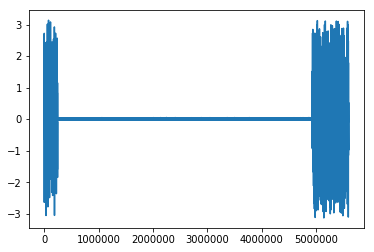

In [8]:
plt.plot(s)

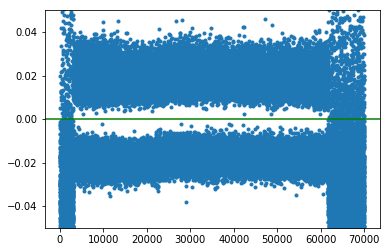

In [9]:
phase = 40
softbits = s[np.int32(np.arange(phase,s.size, 80))]
softbits = softbits - 5e-8 * np.arange(softbits.size) - 1e-3 # correction for frequency offset and drift
plt.plot(softbits,'.')
plt.axhline(y = 0, color='green')
plt.ylim([-0.05,0.05]);

Soft bits are now converted to hard bits.

In [11]:
bits = (softbits > 0)*1

Now we undo GMSK precoding, since we want to export the OQPSK bits. This part is tricky and use the knowledge of the ASM to correct for phase ambiguities.

As a first step, since the GMSK bits are differential phase, a cumulative sum of them gives phase, which can be converted to the QPSK constellation.

In [12]:
decbits = np.cumsum(np.int32(2*bits-1))%4
decbits[::2] = (decbits[::2] == 1)*1
decbits[1::2] = (decbits[1::2] == 0)*1

However we need to consider another branch in which I and Q are swapped, so the sign of one of them is inverted (consider swapping I and Q versus multiplying by 1j).

In [13]:
decbits_inv = decbits.copy()
decbits_inv[::2] ^= 1

We correlate both branches against the uncoded ASM. Note the correlation can happen on either branch and have either sign.

/usr/lib64/python3.6/site-packages/scipy/signal/signaltools.py:492: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/usr/lib64/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/lib64/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


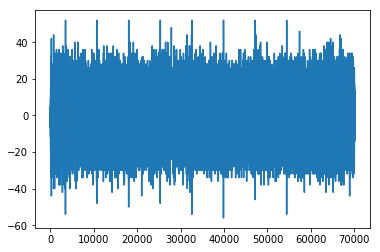

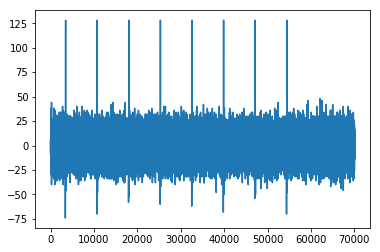

In [14]:
asm = np.unpackbits(np.array([0x03,0x47,0x76,0xC7,0x27,0x28,0x95,0xB0, 0xFC, 0xB8, 0x89, 0x38, 0xD8, 0xD7, 0x6A, 0x4F], dtype='uint8'))
asm_straight_corr = scipy.signal.correlate(2*decbits-1, 2*asm.astype('float')-1)
asm_inv_corr = scipy.signal.correlate(2*decbits_inv-1, 2*asm.astype('float')-1)
plt.figure()
plt.plot(asm_straight_corr)
plt.figure()
plt.plot(asm_inv_corr);

We take note of all correlation positions, the branch where they happen and their sign to correct the phase and output packets that can be fed into the GNU Radio decoder. Note that we're always dealing with hard bits for simplicity.

In [26]:
corr_positions = np.sort(np.concatenate((np.where(np.abs(asm_straight_corr) > 100)[0], np.where(np.abs(asm_inv_corr) > 100)[0])))
with open('/tmp/dslwp_bits', 'w') as file:
    for st in corr_positions:
        if np.abs(asm_straight_corr[st]) > 100:
            b = np.sign(asm_straight_corr[st])*(2*decbits[st+1:st+1+7152]-1)
        else:
            b = np.sign(asm_inv_corr[st])*(2*decbits_inv[st+1:st+1+7152]-1)
        b.astype('float32').tofile(file)

Now we plot the phase of the signal in the problematic zone. The change in slope shows the frequency jump.

/usr/lib64/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


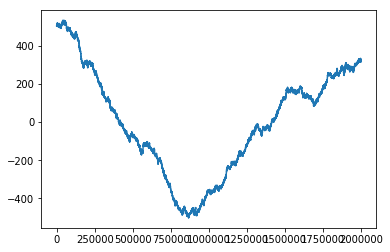

In [24]:
phase = np.unwrap(np.angle(x[1000000:3000000]).astype('float32'))
plt.plot(scipy.signal.detrend(phase))